# <a id='toc1_'></a>[ARIMA](#toc0_)
------

**Table of contents**<a id='toc0_'></a>    
- [ARIMA Pre-Processing & Data Analysis](#toc1_)    
  - [Import Libraries](#toc1_1_)    
  - [Get Data](#toc1_2_)    
  - [Set Path](#toc1_3_)    
  - [ADF Test](#toc1_4_)    
  - [Diff data and remove outliers](#toc1_5_)    
  - [Test Stationarity again](#toc1_6_)    
  - [Show Distribution of data](#toc1_7_)    
  - [PACF & ACF plots](#toc1_8_)    
  - [Plot Diff Data](#toc1_9_)    
  - [White Noise Test for Analytical Value](#toc1_10_)   
- [Model Initialization & Residual Analysis](#toc2_)    
  - [Initaite the model](#toc2_1_)    
  - [Heat Map](#toc2_2_)    
  - [Model Summary as Latex](#toc2_3_)    
  - [White Noise test for model residuals](#toc2_4_)    
  - [Forecast vs Actual (400 days)](#toc2_5_)    
  - [Get Metrics for ARIMA](#toc2_6_)    
  - [Random Walk and Prediction of the next value](#toc2_7_)    
  - [Plot Distribution of Residuals](#toc2_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->
----

## <a id='toc1_1_'></a>[Import Libraries](#toc0_)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tabulate import tabulate
import LSTMpy as lstm
import warnings
import arima as ar
import tqdm as tqdm
from tqdm import tqdm

## set random seed
np.random.seed(42)


## <a id='toc1_2_'></a>[Get Data](#toc0_)

In [2]:
## Get the data for the respective variable to model
column = "SEKDKK"

data = pd.read_csv("20_year_data.csv", delimiter=";")

data['Date'] = pd.to_datetime(data['Date'], format = '%d/%m/%Y')
data = data.set_index('Date')

data = data.replace(to_replace=",", value=".", regex=True)

## Convert all columns to float using regex
data = data.replace(to_replace="[^0-9.]", value="", regex=True)

## Convert all columns to numeric 
data = data.apply(pd.to_numeric)

## choose only the "Value" column with iloc
data = data.iloc[:, 2:3]

data


,Value
Date,
2003-05-02,0.8150
2003-05-05,0.8173
2003-05-06,0.8173
2003-05-07,0.8173
2003-05-08,0.8153
...,...
2023-04-25,0.6592
2023-04-26,0.6573
2023-04-27,0.6540


## <a id='toc1_3_'></a>[Set Path](#toc0_)

In [3]:
import os
if not os.path.exists(f"ARIMA {column}"):
    os.makedirs(f"ARIMA {column}")

# set the path the folder where the models are saved

pwd = os.getcwd()

path = pwd + f"/ARIMA {column}/"

print(path)

/Users/vg/Desktop/BSc.-Economics-Comparative-Analysis-of-the-ARIMA-and-LSTM-Models-for-Exchange-Rate-Prediction./Model – BA/ARIMA SEKDKK/


## <a id='toc1_4_'></a>[ADF Test](#toc0_)

In [4]:
## save the ADF table to latex
ar.test_stationarity(data.values, column, "Before")

ADF Statistic: -1.0748339567894727
p-value: 0.7250027978664912
Critical Values:
	1%: -3.4316595802782865
	5%: -2.8621186927706463
	10%: -2.567078038881065
The series is not stationary
\begin{tabular}{lr}
\hline
 ADF Statistic                                                    & -1.07483  \\
 p-value                                                          &  0.725003 \\
 1\%                                                               & -3.43166  \\
 5\%                                                               & -2.86212  \\
 10\%                                                              & -2.56708  \\
 The series is not stationary as the p-value is greater than 0.05 &           \\
\hline
\end{tabular}


## <a id='toc1_5_'></a>[Diff data and remove outliers](#toc0_)

In [5]:
diff_data = ar.diff_outliers(data, "SEKDKK")

\begin{tabular}{lr}
\hline
 Removed outliers             &    1 \\
 Total number of observations & 5028 \\
\hline
\end{tabular}


## <a id='toc1_6_'></a>[Test Stationarity again](#toc0_)

In [6]:
mean = ar.test_stationarity(diff_data.values, 'SEKDKK')

ADF Statistic: -13.666826369964042
p-value: 1.4852359341083196e-25
Critical Values:
	1%: -3.4316601050096995
	5%: -2.8621189245940792
	10%: -2.5670781622897416
The series is stationary
\begin{tabular}{lr}
\hline
 ADF Statistic                                             & -13.6668      \\
 p-value                                                   &   1.48524e-25 \\
 1\%                                                        &  -3.43166     \\
 5\%                                                        &  -2.86212     \\
 10\%                                                       &  -2.56708     \\
 The series is stationary as the p-value is less than 0.05 &               \\
\hline
\end{tabular}


## <a id='toc1_7_'></a>[Show Distribution of data](#toc0_)

(4817, 1)
(210, 1)


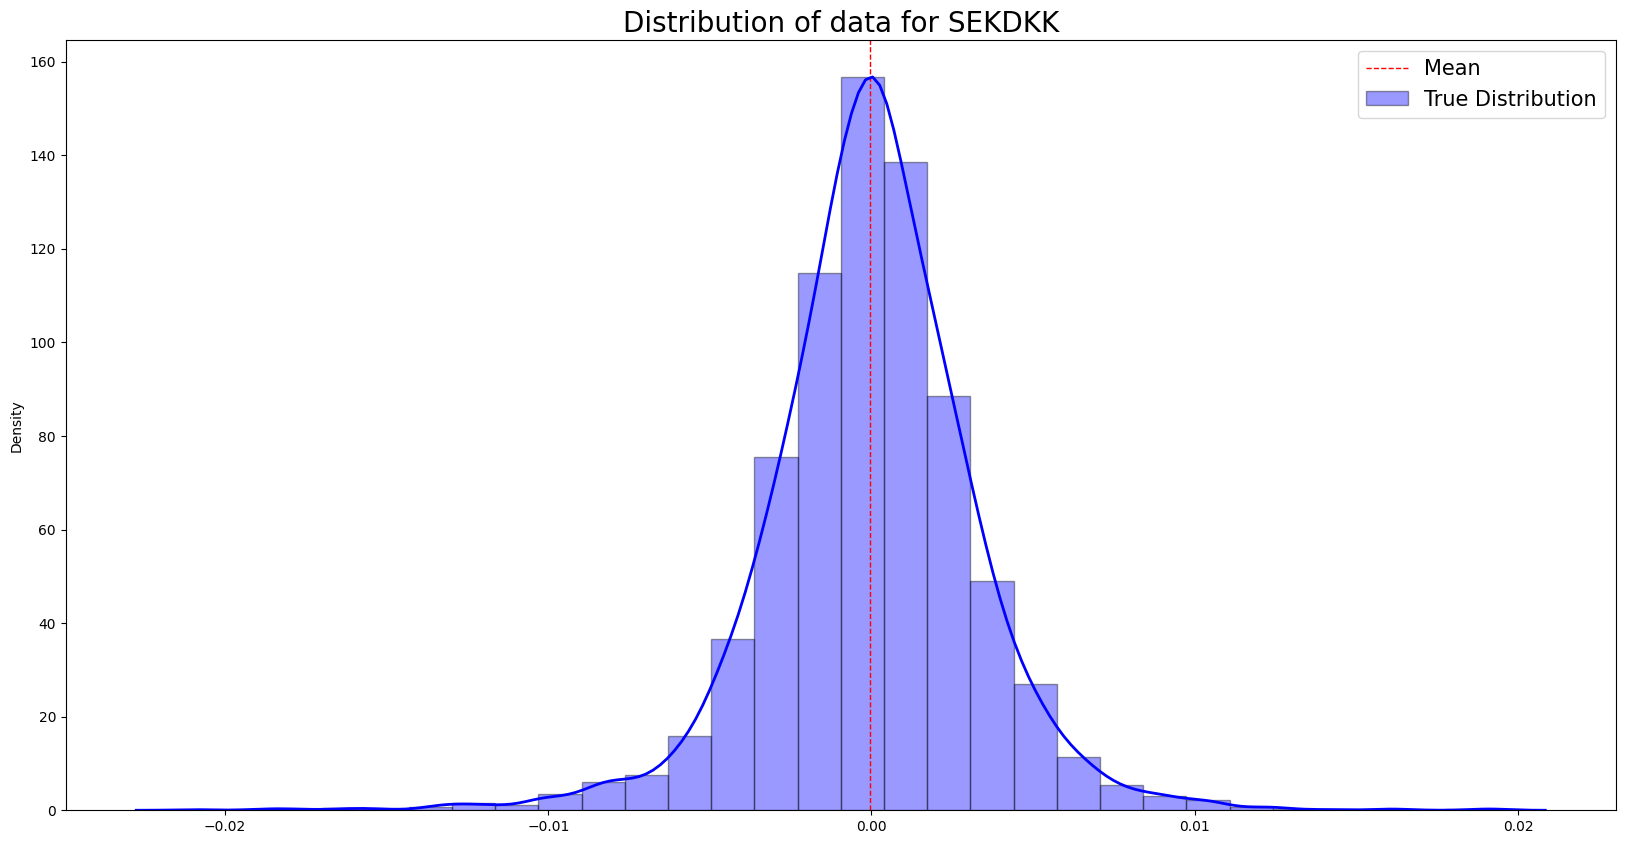

-3.105231748557786e-05

In [7]:
## Split into train and test
data_train = diff_data[:-210]
data_test = diff_data[-210:]

print(data_train.shape)
print(data_test.shape)

#ignore warnings
warnings.filterwarnings("ignore")

ar.distribution(diff_data, "SEKDKK")

## <a id='toc1_8_'></a>[PACF & ACF plots](#toc0_)


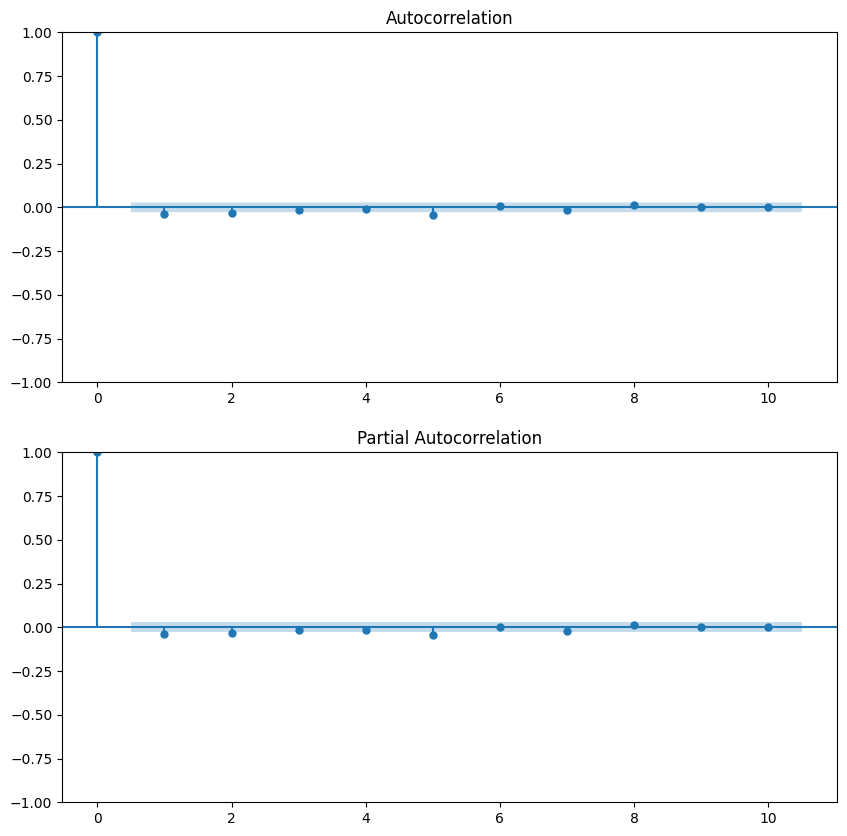

In [8]:
## plot acf and pacf in a 2x1 grid for the diff_data
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(diff_data.values.squeeze(), lags=10, ax=plt.gca())
plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(diff_data.values.squeeze(), lags=10, ax=plt.gca())

## Save fig to path
plt.savefig(f"ARIMA {column}_acf_pacf.png")

plt.show()

## <a id='toc1_9_'></a>[Plot Diff Data](#toc0_)

-3.105231748557786e-05


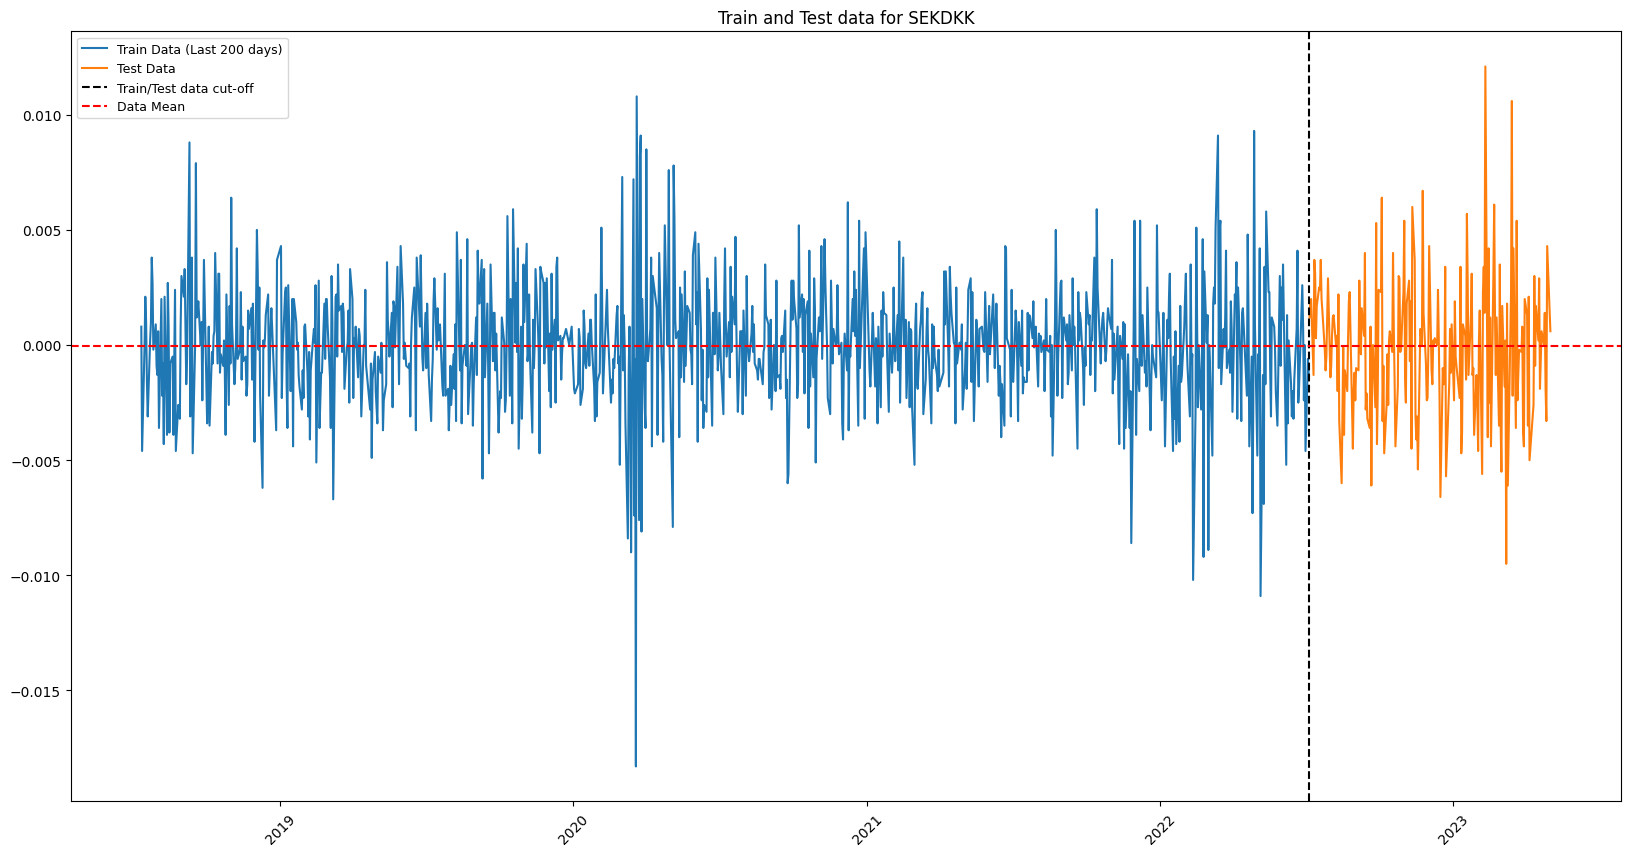

In [9]:
ar.plot_all(data_train, data_test, diff_data, column, mean)

## <a id='toc1_10_'></a>[White Noise Test for Analytical Value](#toc0_)

In [10]:
#White Noise Test
ar.white_noise(diff_data, 1,  "SEKDKK")

The p-value from the white noise test is 0.00901118482351951
The data is not white noise
\begin{tabular}{ll}
\hline
 S   & E                   \\
\hline
 Lag & p-value             \\
 1   & 0.00901118482351951 \\
\hline
\end{tabular}


0.00901118482351951

# <a id='toc2_'></a>[Model Initialization](#toc0_)

## <a id='toc2_1_'></a>[Initaite the model](#toc0_)

In [11]:
model, aic_matrix, p, q = ar.model_initialise(data_train, data_test, column, mean, diff_data)

100%|██████████| 10/10 [04:29<00:00, 26.90s/it]


The p and q values are 0 and 3 respectively
The AIC value is -43458.122759613645
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 5027
Model:                 ARIMA(0, 1, 3)   Log Likelihood               21733.061
Date:                Thu, 04 May 2023   AIC                         -43458.123
Time:                        10:22:18   BIC                         -43432.033
Sample:                             0   HQIC                        -43448.981
                               - 5027                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0396      0.012    -88.336      0.000      -1.063      -1.017
ma.L2          0.0029      0.015      0.201      0

## <a id='toc2_2_'></a>[Heat Map](#toc0_)

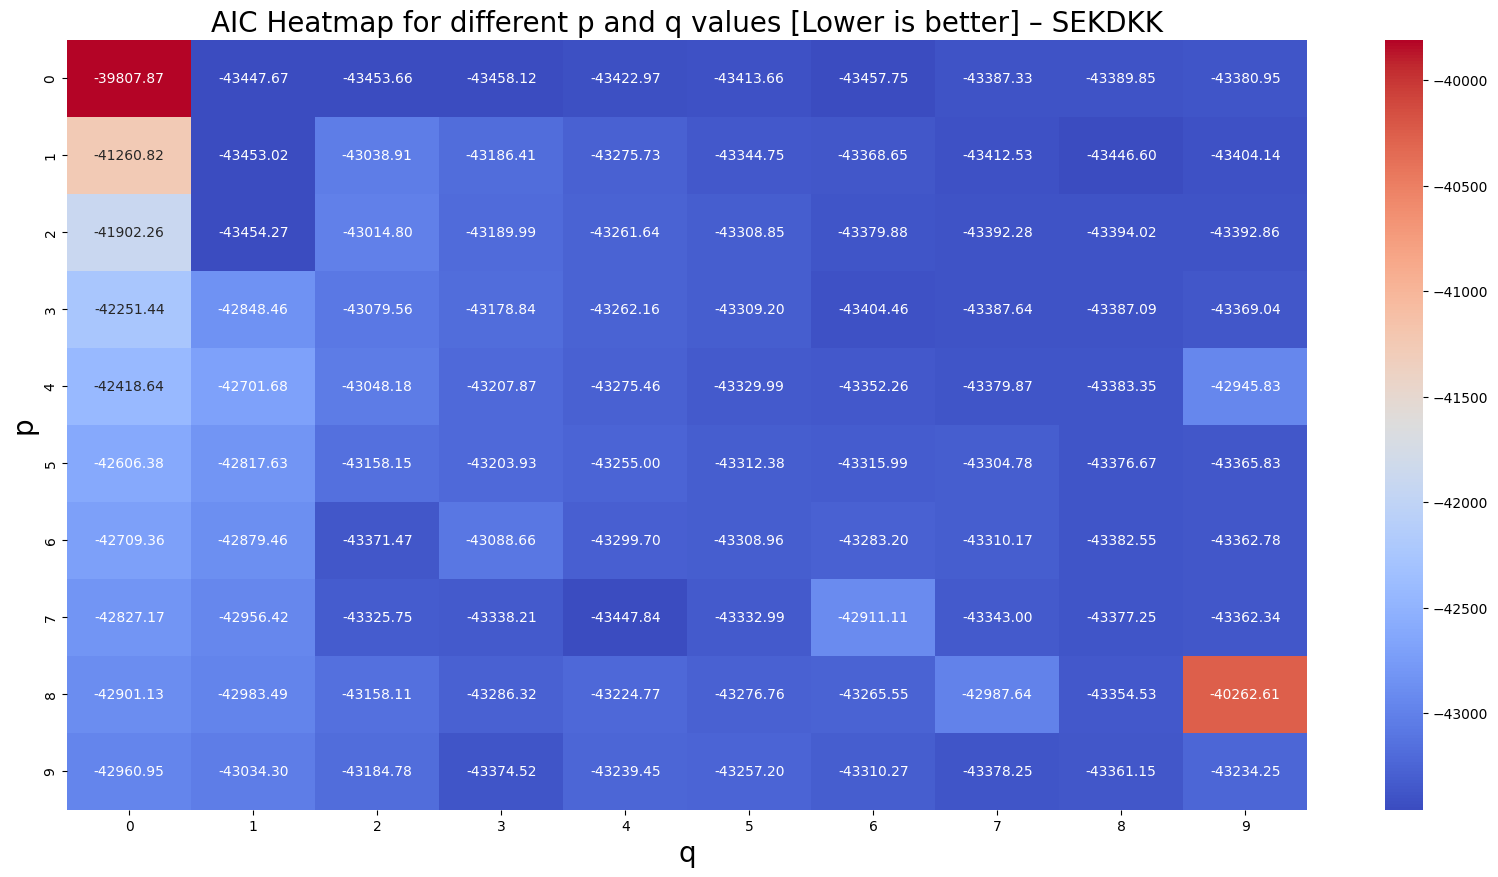

The best p and q values are
(array([0]), array([3]))


In [12]:
## Plot heatmap of AIC values – Lower is Better

ar.heatmap(aic_matrix, column)

## <a id='toc2_3_'></a>[Model Summary as Latex](#toc0_)

In [13]:
## model summary for the best model which draws from the heatmap
# get p and q value for the best model
p = aic_matrix.argmin()//10
q = aic_matrix.argmin()%10

print(f"The best p and q values are {p} and {q} respectively")

model = sm.tsa.ARIMA(diff_data, order=(p,1,q)).fit()

# print summary in latex
print(model.summary().as_latex())

The best p and q values are 0 and 3 respectively
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &      Value       & \textbf{  No. Observations:  } &    5027     \\
\textbf{Model:}                  &  ARIMA(0, 1, 3)  & \textbf{  Log Likelihood     } & 21733.061   \\
\textbf{Date:}                   & Thu, 04 May 2023 & \textbf{  AIC                } & -43458.123  \\
\textbf{Time:}                   &     10:22:19     & \textbf{  BIC                } & -43432.033  \\
\textbf{Sample:}                 &        0         & \textbf{  HQIC               } & -43448.981  \\
\textbf{}                        &      - 5027      & \textbf{                     } &             \\
\textbf{Covariance Type:}        &       opg        & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\text

## <a id='toc2_4_'></a>[White Noise test for model residuals](#toc0_)

In [14]:
## find residuals for the model
residuals = model.resid

ar.white_noise(residuals, 1, ["Lags", "P-Value Residuals"])



The p-value from the white noise test is 0.9701011078812184
The data is white noise
\begin{tabular}{ll}
\hline
 Lags   & P-Value Residuals   \\
\hline
 Lag    & p-value             \\
 1      & 0.9701011078812184  \\
\hline
\end{tabular}


0.9701011078812184

## <a id='toc2_5_'></a>[Forecast vs Actual (400 days)](#toc0_)

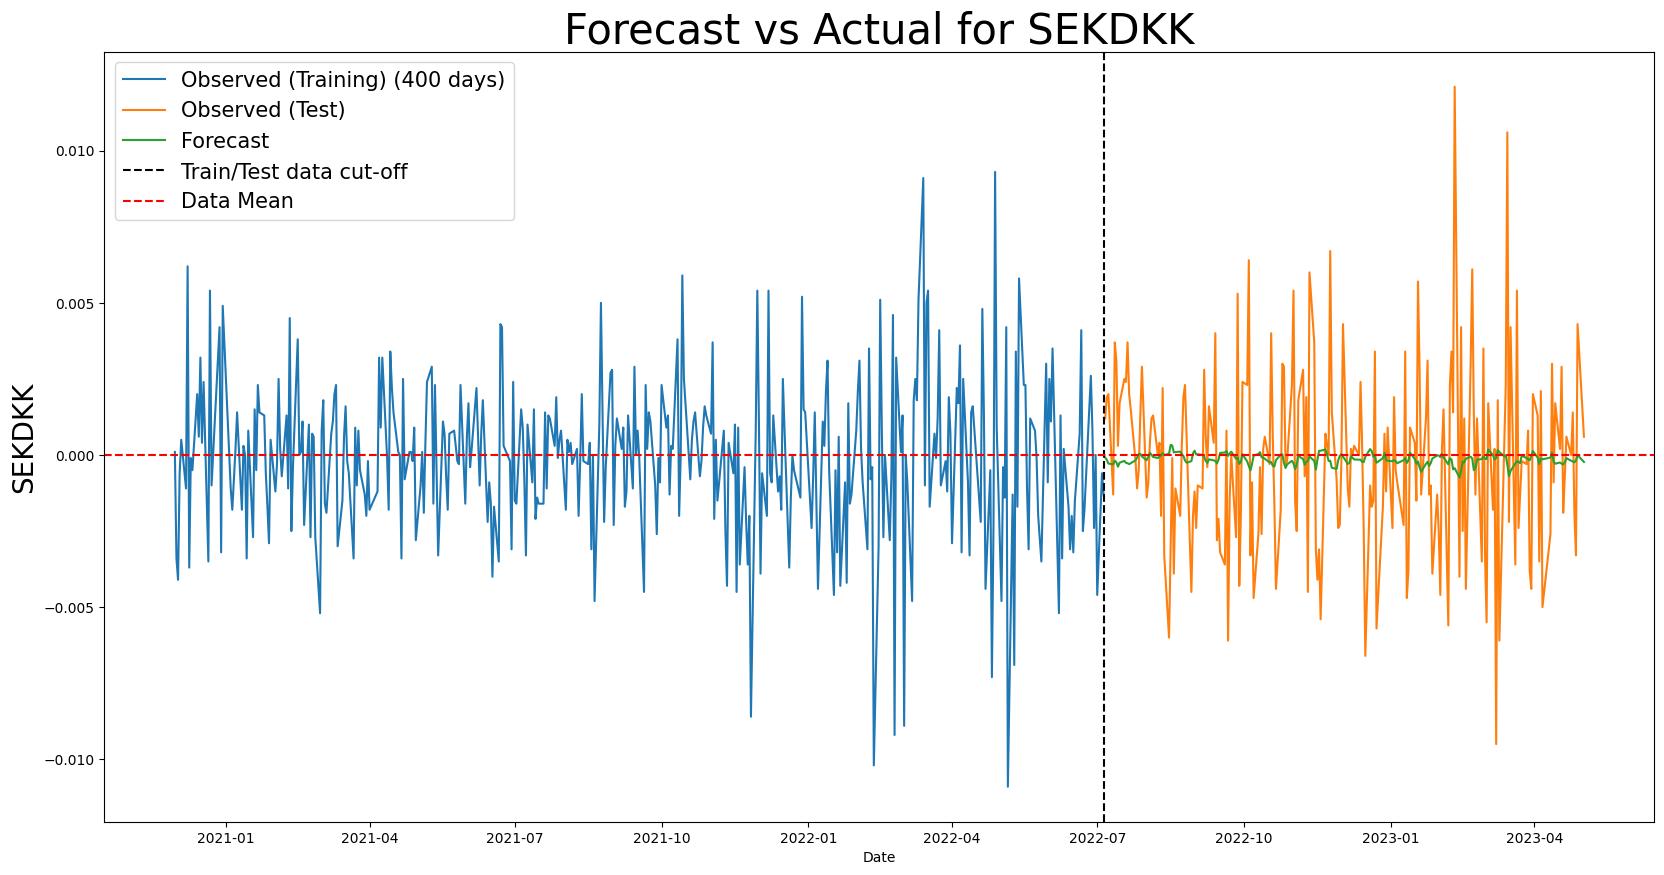

In [15]:
## Plot and get forecast
mean = residuals.mean()
mean = float(mean)

forecast = ar.plot_forecast_comparison(model, data_train, data_test, column, mean, 210)

## <a id='toc2_6_'></a>[Get Metrics for ARIMA](#toc0_)

In [16]:
# Get model metrics, R^2, MSE, MAE, MAPE, RMSE for the forecast and the test data
ar.get_metrics(data_test, forecast)


\begin{tabular}{lr}
\hline
 R2   & -0.0148222   \\
 MSE  &  9.35755e-06 \\
 MAE  &  0.00236452  \\
 MAPE &  1.80592e+10 \\
 RMSE &  0.00305901  \\
\hline
\end{tabular}


[['R2', -0.014822175679521488],
 ['MSE', 9.357552398711431e-06],
 ['MAE', 0.002364520477654911],
 ['MAPE', 18059212246.287792],
 ['RMSE', 0.0030590116702476685]]

## <a id='toc2_7_'></a>[Random Walk and Prediction of the next value](#toc0_)

In [20]:
ar.direction_counter(forecast, data_test, column)

\begin{tabular}{lll}
\hline
                                  & ARIMA SEKDKK   & Random walk   \\
\hline
 Total number of predictions      & 209            & 209           \\
 Number of correct directions     & 145            & 103           \\
 Number of false directions       & 64             & 106           \\
 Percentage of correct directions & 69.38\%         & 49.28\%        \\
 Percentage of false directions   & 30.62\%         & 50.72\%        \\
\hline
\end{tabular}


## <a id='toc2_8_'></a>[Plot Distribution of Residuals](#toc0_)

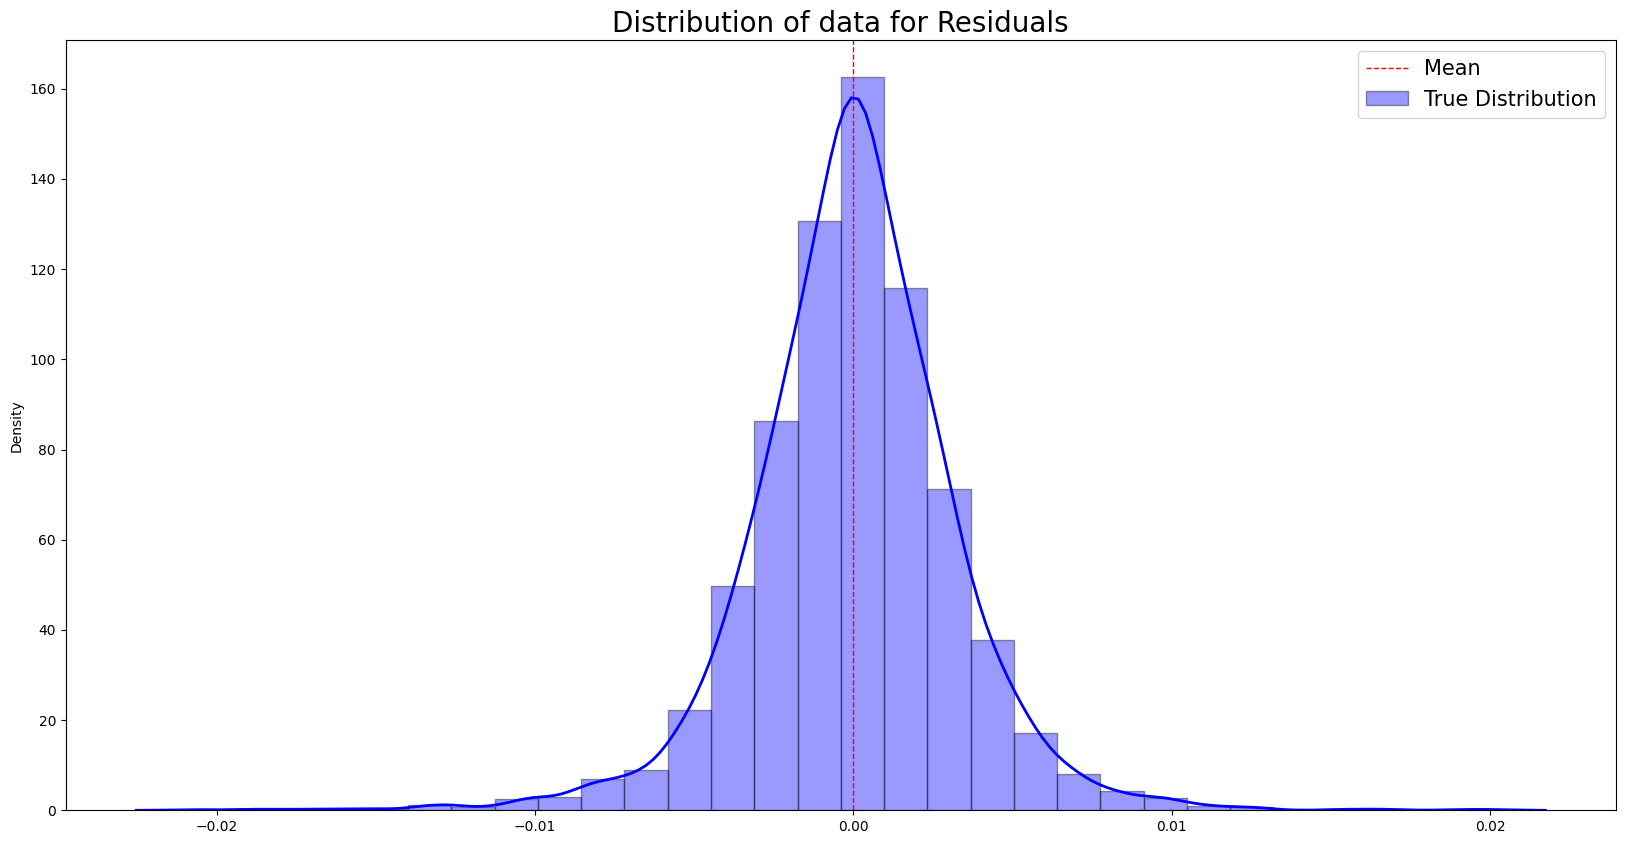

-5.043472741514645e-06

In [21]:
# Plot distribution of data 
ar.distribution(residuals, "Residuals")